# Oppgave 6 – Prediktiv Analyse
Denne notebooken bruker ferdiglagde funksjoner fra `src/` for å gjennomføre dataanalyse og prediksjon.


## 1. Importer nødvendige funksjoner og biblioteker

In [9]:
import sys
import os
sys.path.append(os.path.abspath("../src"))


import pandas as pd
from opg6_databehandling import Databehandling
from opg6_visualisering import PollutionVisualizer
from opg6_analyse import tren_modell, bør_ta_med_paraply, lagre_modell
from opg6_skydekkemodel import SkydekkePredictor
import matplotlib.pyplot as plt


## 2. Les inn og forbered data


In [13]:

df_klima, df_luft = Databehandling.les_og_forbered_data("../data/R_Sammenslaaing_uten_feil.csv", "../data/R_luftkvalitet.csv")
df = Databehandling.slå_sammen_data(df_klima, df_luft)
df = Databehandling.fjern_outliers(df, "no2", 300)

#### Sjekker om datasettene har manglende datoer/rader siden antall rader er forksjellig:

In [ ]:
df_luft_daily, df_luft_fylt = Databehandling.resample_og_interpoler(df_luft)

Antall manglende verdier før interpolering:
pm2_5    6
pm10     6
no2      6
o3       6
dtype: int64

Antall manglende verdier etter interpolering:
pm2_5    0
pm10     0
no2      0
o3       0
dtype: int64


#### Ser at luftkvalitet har noen manglende rader. Bruker linær regresjonsmetode til å lage tilnærmet verdi for de manglende radene:

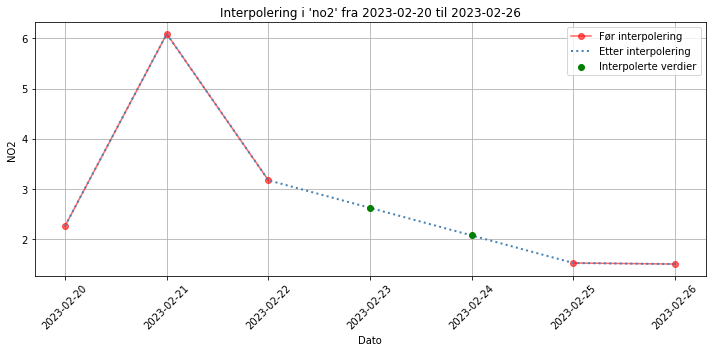

In [ ]:
kolonne = "no2"
start_dato = "2023-02-20"
slutt_dato = "2023-02-26"

PollutionVisualizer.plot_interpolation(df_luft_daily, df_luft_fylt, kolonne, start_dato, slutt_dato)


#### For å vise tydlig hvordan interpoleringen er gjort blir det kun plottet et lite intervall. Plottet viser hvordan interpoleringen er blitt gjort for de manglende verdiene. 

## 3. Visualisering


#### Et linjediagram er brukt for å plotte NO₂-data fordi det gir en tydelig visuell fremstilling av konsentrasjonen over tid og gjør det enkelt å identifisere manglende verdier eller uteliggere i datasettet. Det gikk ikke å hente ut historisk data for luftkvalitet fra MET som ble tidligere brukt og dataen ble derfor hentet ut ved openweatherma. Videre plottes data for å se om det mangler eller uteliggere. 

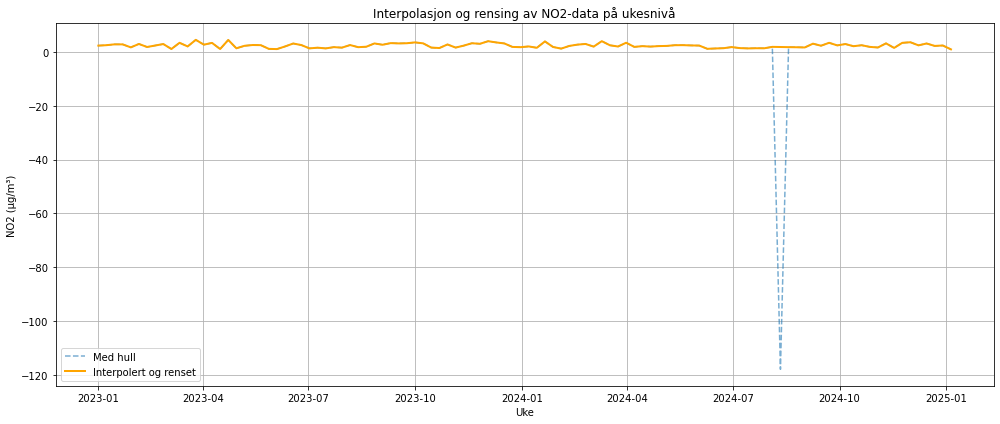

In [ ]:

weekly_no2_clean = Databehandling.fjern_iqr_outliers(weekly_no2)
PollutionVisualizer.plot_ukentlig_no2(weekly_no2, weekly_no2_clean)


#### Ser at den er en verdi som er ugyldig, sjekker dette ved å printe ut de 10 laveste verdiene i datasettet:

In [ ]:
print(weekly_no2.sort_values().head(10))

date
2024-08-11   -117.918571
2025-01-05      0.920000
2023-06-04      1.034286
2023-04-16      1.058571
2023-03-05      1.068571
2023-05-28      1.110000
2024-06-09      1.131429
2024-02-04      1.204286
2024-06-16      1.265714
2023-07-16      1.284286
Name: no2, dtype: float64


#### Ser uteligger på 08.11.2024 da dette ikke er en gyldig verdi for NO2. Metoden for å behandle uteliggere er Interquartile Range (IQR).
Utregningen er gjort i "opg6_databehandling" og er:<br>
Q1 = serie.quantile(0.25)<br>
Q3 = serie.quantile(0.75)<br>
IQR = Q3 - Q1<br>
lower_bound = Q1 - 1.5 * IQR <br>
upper_bound = Q3 + 1.5 * IQR<br>

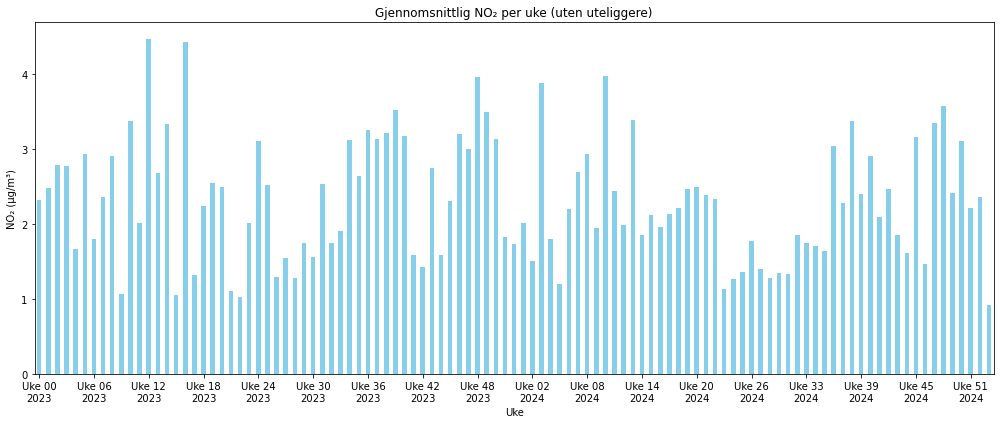

In [ ]:

weekly_no2 = df_luft_daily["no2"].resample("W").mean()
weekly_no2_clean = Databehandling.fjern_iqr_outliers(weekly_no2)

PollutionVisualizer.plot_no2_ukentlig_barplot(weekly_no2_clean)


# Heatmap

Bruker heatmap til å se korrelasjon mellom alle verdiene. Dette kan brukes videre til å se hva som er interessant å lage visuallisering av.

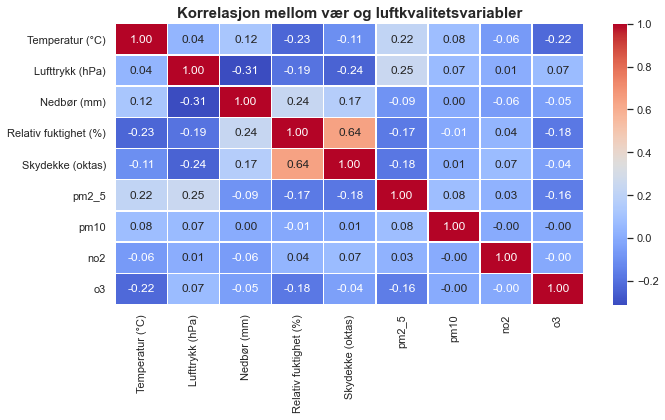

In [ ]:
vis_korrelasjonsmatrise(df)

Ser fra heatmap at skydekke og relativ luftfuktighet har sterk korrelasjon. Ser også at nedbør og lufttrykk har sterk korrelasjon. Begge disse stemmer sterkt overens, noe som er i tråd med meteorologisk forskning, der det ofte observeres at værforhold som høy luftfuktighet og økt skydekke opptrer samtidig, samt at nedbør ofte henger sammen med lavt lufttrykk.

# Linjediagramemed Seaborn
Linjediagram er brukt for å visualisere skydekke og relativ luftfuktighet fordi denne diagramtypen egner seg godt til å vise hvordan verdier utvikler seg over tid. I tillegg gjør linjediagram det enklere å sammenligne to tidsserier (skydekke og luftfuktighet) ved å bruke to y-akser, og å se samvariasjon mellom dem.

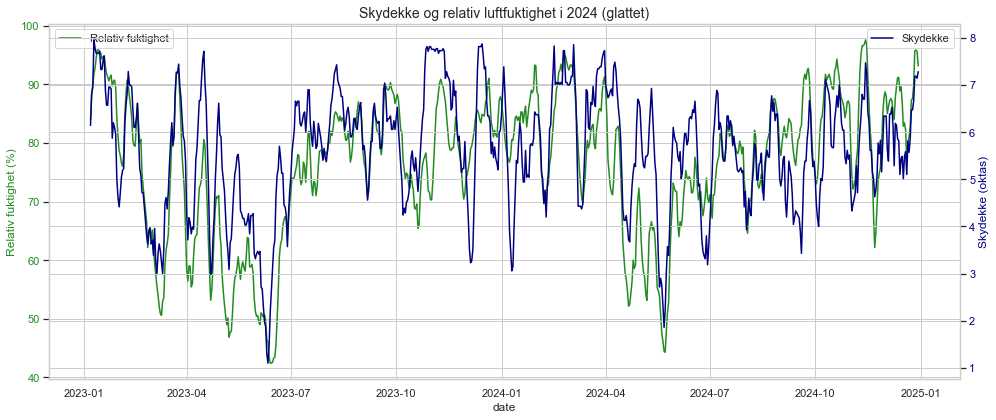

In [ ]:
plott_skydekke_fuktighet(df)


## 4. Tren og evaluer prediktiv modell


In [ ]:
features = ["Temperatur (°C)", "Lufttrykk (hPa)", "Relativ fuktighet (%)"]
target = "Skydekke (oktas)"

modell, scaler, metrics, X_test, y_test, y_pred = tren_modell(df, features, target)
print(f"MSE: {metrics['mse']:.2f}, R²: {metrics['r2']:.2f}, RMSE: {metrics['rmse']:.2f}")


MSE: 2.87, R²: 0.38, RMSE: 1.69


MSE: 2.87
R²: 0.38
RMSE: 1.69


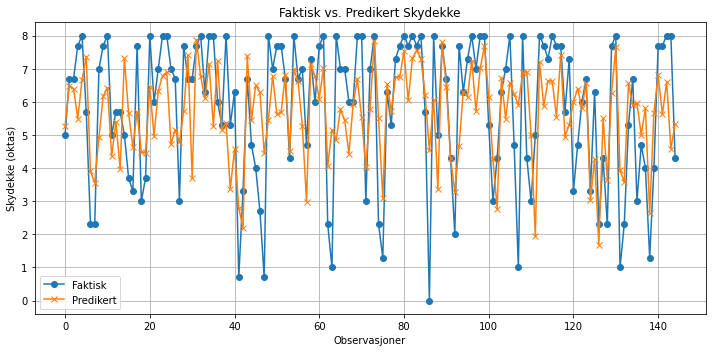

In [ ]:


df_klima, df_luft = Databehandling.les_og_forbered_data("../data/R_Sammenslaaing_uten_feil.csv", "../data/R_luftkvalitet.csv")
df_samlet = Databehandling.slå_sammen_data(df_klima, df_luft)

sp = SkydekkePredictor(df_samlet)
sp.tren_og_evaluer()
sp.lagre_modell()


Mean square error regner ut gjennomsnittet av kvadrerte feil mellom de faktiske og predikerte veridene. 
RMSE er da roten av MSE og sier at feilmarginen på de predikerte veridene er i snitt 2.87. Dette betyr at modellen bommer i sitt +/- 2.87 oktas.

R*2 sier hvor mye av variasjonen skydekke-modellen som forklares av modellen. 0.38  vil si at 38% kan forklares av temperatur, lufttrykk og luftfuktighet. Dette tilsvarer ikke mye, men modellen er noe fungerende.

## 5. Anbefaling basert på en tilfeldig observasjon
Velger en random simulering for å simulere en dag og sier til bruker om sjangsen for regn ut i fra skydekke og fuktighet og da om man bør ta med paraply:
 

In [ ]:
import random
ny_observasjon = X_test.sample(1, random_state=random.randint(1, 10000))
pred = modell.predict(scaler.transform(ny_observasjon))[0]
fukt = ny_observasjon["Relativ fuktighet (%)"].values[0]
print(f"Skydekke: {pred:.2f}, Fuktighet: {fukt:.1f}%")
print(bør_ta_med_paraply(pred, fukt))


Skydekke: 6.18, Fuktighet: 81.0%
Ta med paraply!


## 6. Lagre modell og scaler


In [ ]:
lagre_modell(modell, scaler, "../modell_skydekke.pkl", "../scaler_skydekke.pkl")


# Evaluering av visualiseringene
Heatmapet gjorde det lettere å se på hva som kan bruker til regresjonsmodellen og hvilke verdiener som var interesant å se korrelasjonen mellom. VIdere Viste linjediagramm hvordan verdiene utviklet seg over tid. I sammenheng med værdata er de da interessant å se forskjell i årstidene og viser blant annet lavere skydekke begge årene på sommeren. Linjediagram visualiserte også godt hvordan manglede verdier blir håndtert av linær regresjon.
Sæylediagrammene ga en tydelig fremmvisning av ukentlig trender og viste tydelig om det var feil i datasettet.
